we first load some spectra and redshift

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys, os, glob, copy, re, shutil

from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
from astropy.convolution import Box1DKernel, convolve
from astroquery.sdss import SDSS
from astropy.wcs import WCS

from astropy.io import fits

import scienceplots

plt.style.use(['bright', 'science', 'no-latex','notebook'])

In [2]:
data_agn_updated = ascii.read('/mnt/c/Users/Chisen/OneDrive - University of Illinois - Urbana/Research/dwarf_agn_cosmos/hsc_agn_updated.txt')
data_agn = ascii.read('/mnt/c/Users/Chisen/OneDrive - University of Illinois - Urbana/Research/dwarf_agn_cosmos/hsc_agn.txt')

ra, dec = data_agn_updated['RAdeg'], data_agn_updated['DEdeg']
data_coords = SkyCoord(ra, dec, unit=[u.deg, u.deg])

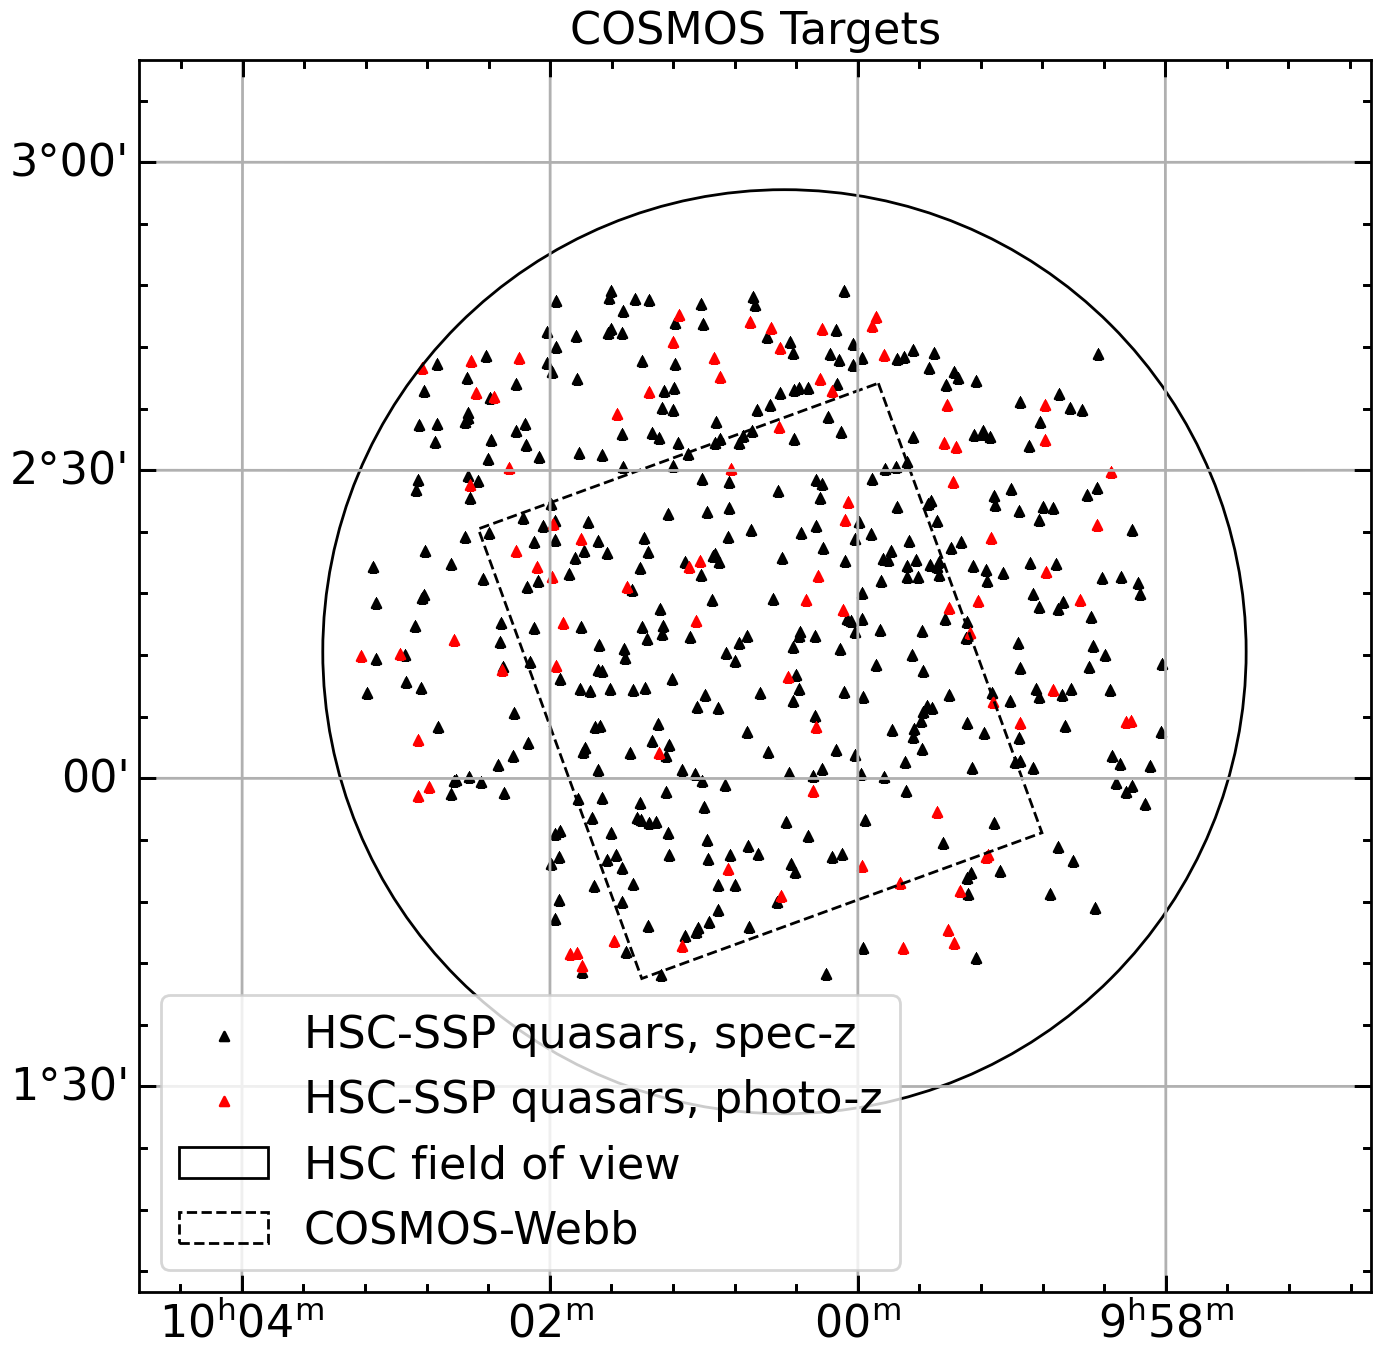

In [8]:
center_coord = SkyCoord("150d10m 2d10m")
width = 1*u.deg
wcs = WCS(naxis=2)
wcs.wcs.crpix = [1, 1]
wcs.wcs.cdelt = [-width.to_value(u.deg), width.to_value(u.deg)]
wcs.wcs.crval = [center_coord.ra.deg, center_coord.dec.deg]
wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
fig = plt.figure(figsize=[8, 8], dpi=100)
ax1 = plt.axes(projection=wcs)
ax1.set_aspect('equal')
mask_sp = np.isin(data_agn_updated['r_z'], [0, 1, 5])
ax1.scatter(ra[mask_sp], dec[mask_sp], transform=ax1.get_transform('world'), s=10, marker='^', color='k', alpha=1, label='HSC-SSP quasars, spec-z')
# With no spectrum
ax1.scatter(ra[~mask_sp], dec[~mask_sp], transform=ax1.get_transform('world'), s=10, marker='^', color='r', alpha=1, label='HSC-SSP quasars, photo-z')
# Add FOVs
#HSC: 10.1093/pasj/psx066 fig4
HSC_center = SkyCoord('10h00m28.60s +02d12m21.00s')
HSC_radius = 0.75
HSC_FOV = plt.Circle((HSC_center.ra.value, HSC_center.dec.value), HSC_radius,
                        fill=False, transform=ax1.get_transform('world'), label='HSC field of view')
ax1.add_artist(HSC_FOV)
#Webb: 2211.07865 fig1
Webb_center = SkyCoord('10h00m27.9s +02d12m03.5s')
Webb_width = 41.5/60
Webb_height = 46.6/60
Webb_angle = 110
Webb_FOV = plt.Rectangle((Webb_center.ra.value-Webb_width/2, Webb_center.dec.value-Webb_height/2),
                        Webb_height, Webb_width, rotation_point='center', angle=-110, linestyle='--',
                        fill=False, transform=ax1.get_transform('world'), label='COSMOS-Webb')
ax1.add_artist(Webb_FOV)
ax1.grid()
ax1.coords['ra'].set_auto_axislabel(False)
ax1.coords['dec'].set_auto_axislabel(False)
ax1.legend(loc='lower left', frameon=True)
ax1.set_title('COSMOS Targets')
ax1.set_xlim(-1, 1) # using deg as unit as defined in wcs.wcs.cdelt
ax1.set_ylim(-1, 1)
# fig.savefig('cosmos.eps', format='eps')
plt.show()

In [9]:
idx_data = []
sdss_targets = []

for i in range(len(data_agn_updated)): 
    pos = data_coords[i]
    xid = SDSS.query_region(pos, radius='0.5 arcsec', spectro=True)
    if xid is None: 
        continue
    if len(xid)>=2: 
        print(i+1, 'has multiple spectra: ')
        xid.pprint_all()
    # else: 
    #     print(i+1, 'has a spectrum')
    sdss_targets.append(xid)
    idx_data.append(i)

len(idx_data)


280 has multiple spectra: 
       ra              dec               objid        run  rerun camcol field    z     plate  mjd  fiberID      specobjid       run2d 
---------------- ---------------- ------------------- ---- ----- ------ ----- -------- ----- ----- ------- ------------------- -------
149.649923129421 1.86584454406202 1237653664721797334 1907   301      3   180 2.937933   500 51994     176  562998365386729472      26
149.649923129421 1.86584454406202 1237653664721797334 1907   301      3   180 2.934358  4737 55630     302 5333470966298466304 v5_13_2
283 has multiple spectra: 
       ra              dec               objid        run  rerun camcol field    z     plate  mjd  fiberID      specobjid       run2d 
---------------- ---------------- ------------------- ---- ----- ------ ----- -------- ----- ----- ------- ------------------- -------
149.744499096753 2.02749573426898 1237653664721862790 1907   301      3   181 2.446672   500 51994     513  563090999241369600      26
1

58

In [23]:
data_agn_download = copy.copy(data_agn_updated)

data_agn_download['spec_sdss'] = False
data_agn_download['z_sdss'] = -1. 
for i in range(len(idx_data)): 
    data_agn_download['spec_sdss'][idx_data[i]] = True
    data_agn_download['z_sdss'][idx_data[i]] = sdss_targets[i]['z'][-1]

In [11]:
sdss_dir = '/mnt/c/Users/Chisen/OneDrive - University of Illinois - Urbana/Research/dwarf_agn_cosmos/spec/sdss'

load data and spectra

In [29]:
data_used = data_agn_download[data_agn_download['spec_sdss']==True]
data_used = data_used['ID', 'z_sdss']

data_used

ID,z_sdss
int64,float64
2,3.503096
7,1.964449
8,2.002805
12,1.517696
24,1.29498
26,0.8165838
28,2.836788
34,0.6573269
36,2.120248


In [38]:
data_used['spec_sdss'] = None

for i, ID in enumerate(data_used['ID']):
    
    if os.path.isfile('/mnt/c/Users/Chisen/OneDrive - University of Illinois - Urbana/Research/dwarf_agn_cosmos/spec/SDSS/sdss_%d.fits'%ID): 
        
        # z_sdss = data_agn_download['z_sdss'][ID-1]

        hdu = fits.open('/mnt/c/Users/Chisen/OneDrive - University of Illinois - Urbana/Research/dwarf_agn_cosmos/spec/SDSS/sdss_%d.fits'%ID)
        mask = np.isfinite(hdu[1].data['flux'])
        flux_sdss = convolve(hdu[1].data['flux'][mask], Box1DKernel(width=10))
        # plt.plot(10**hdu[1].data['loglam'][mask], flux_sdss,
        #          label=f'SDSS (z={z_sdss})', color='bisque', linewidth=1);
        
        # mask = np.isfinite(flux_sdss)
        # # ylim = np.max([ylim, np.nanmax(flux_sdss[mask])])
        # plt.show()
        data_used['spec_sdss'][i] = flux_sdss

In [41]:
data_used

ID,z_sdss,spec_sdss
int64,float64,object
2,3.503096,[ 3.0981514 3.2805538 3.2138364 ... -0.4458007 -0.4835227\n -0.23445086]
7,1.964449,[3.159988 3.5302465 4.2038445 ... 1.3414261 1.2299198 1.0782471]
8,2.002805,[ 7.3482103 8.851166 10.515259 ... 1.928333 1.7331293 1.6054761]
12,1.517696,[2.9695315 3.5894563 3.9259272 ... 0.94993556 0.7889638 0.6004343 ]
24,1.29498,[3.5984263 3.9862902 4.4195385 ... 0.636673 0.4775936 0.36652195]
26,0.8165838,[ 2.1330068 2.380124 1.6383008 ... -0.8630246 -0.70636976\n -0.01306987]
28,2.836788,[1.9543664 2.3663187 2.2342982 ... 0.3530498 0.39357358 0.89810663]
34,0.6573269,[12.9117565 15.081478 17.273003 ... 3.0781853 2.7510052 2.3495097]
36,2.120248,[1.0297496 1.2198974 1.6704905 ... 1.347306 1.9933274 1.7795227]


### Now we load the data into NN.

parse data

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from astropy.table import Table
import torch
from torch.utils.data import Dataset, DataLoader

# Load the data (assuming it's already loaded into an astropy table named `data_used`)
# data_used = Table.read('path_to_file')  # Uncomment if loading from a file

# Extract spectral data and specz from the table
spectra = [list(row['spec_sdss']) for row in data_used]
specz = list(data_used['z_sdss'])

# Convert spectra to a NumPy array for processing
import numpy as np
spectra = np.array(spectra)
specz = np.array(specz)

# Normalize the spectra
spectra = (spectra - spectra.mean(axis=1, keepdims=True)) / spectra.std(axis=1, keepdims=True)
# Normalize the specz values
specz = (specz - specz.min()) / (specz.max() - specz.min())


Custom Dataset Class

In [ ]:
class SpectraDataset(Dataset):
    def __init__(self, spectra, specz):
        self.spectra = torch.tensor(spectra, dtype=torch.float32)
        self.specz = torch.tensor(specz, dtype=torch.float32)

    def __len__(self):
        return len(self.spectra)

    def __getitem__(self, idx):
        return self.spectra[idx], self.specz[idx]

# Create training and testing datasets
split_idx = int(0.8 * len(spectra))
train_spectra, test_spectra = spectra[:split_idx], spectra[split_idx:]
train_specz, test_specz = specz[:split_idx], specz[split_idx:]

train_dataset = SpectraDataset(train_spectra, train_specz)
test_dataset = SpectraDataset(test_spectra, test_specz)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


NN definition

In [ ]:
class SpeczPredictor(nn.Module):
    def __init__(self, input_dim):
        super(SpeczPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Single output for regression
        )

    def forward(self, x):
        return self.network(x).squeeze()


training and testing

In [ ]:
# Instantiate model, loss, and optimizer
model = SpeczPredictor(input_dim=train_spectra.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for spectra_batch, specz_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(spectra_batch)
        loss = criterion(predictions, specz_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}')

# Testing loop
model.eval()
test_loss = 0
with torch.no_grad():
    for spectra_batch, specz_batch in test_loader:
        predictions = model(spectra_batch)
        loss = criterion(predictions, specz_batch)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')
